In [1]:
#import libraries
%matplotlib inline
import os.path
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import matplotlib.pyplot as plt

In [2]:
# Read in the Xtrain, Xtest, ytrain, ytest datasets
Xtrain = pd.read_csv('Resources/X_train_actual_balanced_scaled_train_dataset.csv')
Xtest = pd.read_csv('Resources/X_test_actual_balanced_scaled_train_dataset.csv')
ytrain = pd.read_csv('Resources/y_train_actual_balanced_scaled_train_dataset.csv')
ytest = pd.read_csv('Resources/y_test_actual_balanced_scaled_train_dataset.csv')

In [3]:
Xtrain.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1.193046,1.054871,-0.488678,-0.343286,0.535557,0.911077,0.947176,0.261246,-0.893721,-0.588710
1,-0.838191,0.657670,-0.488678,-0.343286,0.535557,-0.117758,-1.055770,-0.261658,0.768508,0.413607
2,-0.838191,-0.578070,-0.488678,-0.343286,0.535557,-2.175429,0.947176,-0.471103,-0.728995,1.415924
3,-0.838191,0.083933,-0.488678,-0.343286,0.535557,-2.175429,-1.055770,0.776694,-0.339645,-1.591027
4,1.193046,-1.857942,-0.488678,-0.343286,-1.867214,1.939913,0.947176,-0.749239,-1.357947,0.413607


In [4]:
#Create our model for the tuner
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=10,
        step=2), activation=activation, input_dim=10))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=10,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [5]:
# create the tuner
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [6]:
# Run the kerastuner search for best hyperparameters
tuner.search(Xtrain, ytrain ,epochs=20,validation_data=(Xtest, ytest))

INFO:tensorflow:Oracle triggered exit


In [7]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 9,
 'num_layers': 1,
 'units_0': 3,
 'units_1': 7,
 'units_2': 5,
 'units_3': 3,
 'units_4': 5,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '488b429b9d72d12ac85129b7a40df5c5'}

In [8]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(Xtest, ytest, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - loss: 0.7379 - accuracy: 0.3929
Loss: 0.7378780245780945, Accuracy: 0.3928571343421936


In [9]:
#get prediction of y from the best model
predictions = best_model.predict(Xtest)

#round predictions for use in confusion matrix
rounded_pred = np.argmax(predictions, axis=1)
rounded_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

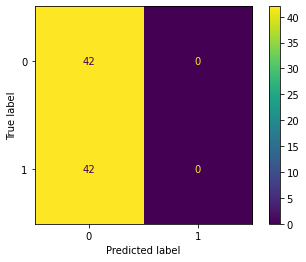

In [10]:
#print confusion matrix
cm = confusion_matrix(ytest, rounded_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()
    

In [11]:
if os.path.isfile('Models/actual_scaled_best.h5') is False:
    best_model.save('Models/actual_scaled_best.h5')